<a href="https://colab.research.google.com/github/Mael-zys/SD212/blob/main/lab2_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SD212: Graph mining
## Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

## Import

In [ ]:
!pip install scikit-network

In [ ]:
from IPython.display import SVG

In [ ]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [ ]:
from sknetwork.data import load_netset, erdos_renyi, cyclic_graph, karate_club
from sknetwork.path import distance, diameter, shortest_path
from sknetwork.utils import bipartite2undirected
from sknetwork.topology import Triangles
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [ ]:
openflights = load_netset('openflights')

Parsing files...
Done.


In [ ]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [ ]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [ ]:
cinema = load_netset('cinema')

Parsing files...
Done.


## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that the degree distributions of these graphs have a power law?

openflight

In [ ]:
n = adjacency.shape[0]
degrees = adjacency.dot(np.ones(n))
degrees_in = adjacency.T.dot(np.ones(n))

In [ ]:
np.std(degrees)/np.mean(degrees)

2.1143999842457535

In [ ]:
adjacency_random = erdos_renyi(n, np.mean(degrees)/(n-1))

degrees_random = adjacency_random.dot(np.ones(n))

In [ ]:
degrees_in

array([4., 7., 8., ..., 1., 1., 1.])

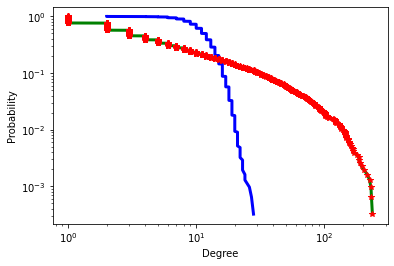

In [ ]:
plt.loglog(np.sort(degrees), 1 - np.arange(n) / n,'g', lw = 3)
plt.loglog(np.sort(degrees_random), 1 - np.arange(n) / n,'b', lw = 3)
plt.loglog(np.sort(degrees_in), 1 - np.arange(n) / n, 'r*', lw = 1)
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.show()

wiki

In [ ]:
adjacency = wikivitals.adjacency
n = adjacency.shape[0]
out_degrees = adjacency.dot(np.ones(n))
in_degrees = adjacency.T.dot(np.ones(n))

In [ ]:
print(np.std(out_degrees)/ np.mean(out_degrees))
print(np.std(in_degrees)/ np.mean(in_degrees))

0.8065909718992998
1.3553811414388752


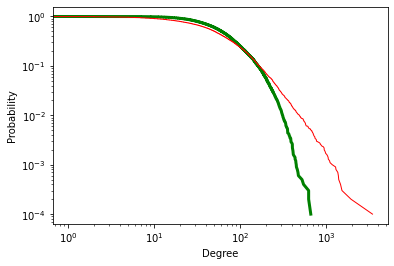

In [ ]:
plt.loglog(np.sort(out_degrees), 1 - np.arange(n) / n,'g', lw = 3)
plt.loglog(np.sort(in_degrees), 1 - np.arange(n) / n, 'r', lw = 1)
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.show()

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Check your code with the function ``distance``.
* Give ones of the longest shortest paths starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
You might use the function ``shortest_path``.<br>
List the corresponding airports and display the path.

In [ ]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    stop = False
    t = 0
    while not stop:
        t += 1
        reached_new = adjacency.T.dot(reached)
        # to be modified   
        stop = np.all(reached_new == reached)
        distances[reached_new & ~reached] = t
        reached |= reached_new
    return distances

In [ ]:
adjacency = openflights.adjacency > 0
distances = get_distances(adjacency, 0)

In [ ]:
distances

array([0., 1., 1., ..., 5., 5., 5.])

In [ ]:
distance(adjacency, 0)

array([0., 1., 1., ..., 5., 5., 5.])

In [ ]:
cdg = 622
airports = openflights.names
print(airports[cdg])

Charles de Gaulle International Airport


In [ ]:
def get_adjacency_path(adjacency, path):
    '''Return a path as an adjacency matrix (subset of edges).'''
    row = path[:-1]
    col = path[1:]
    data = np.ones(len(row), dtype=bool)
    adjacency_path = sparse.csr_matrix((data, (row, col)), shape=adjacency.shape)
    return adjacency_path

In [ ]:
# a random shortest path
source, dest = 900, 2500
print(airports[source], '->', airports[dest])
path = shortest_path(adjacency, source, dest)

Pago Pago International Airport -> Al Ain International Airport


In [ ]:
# representation as a sparse matrix
adjacency_path = get_adjacency_path(adjacency, path)

In [ ]:
# display
position = openflights.position
image = svg_graph(adjacency_path, position, directed=True, height=400, width=800, 
                  node_size=1, edge_width=3, edge_color='blue')

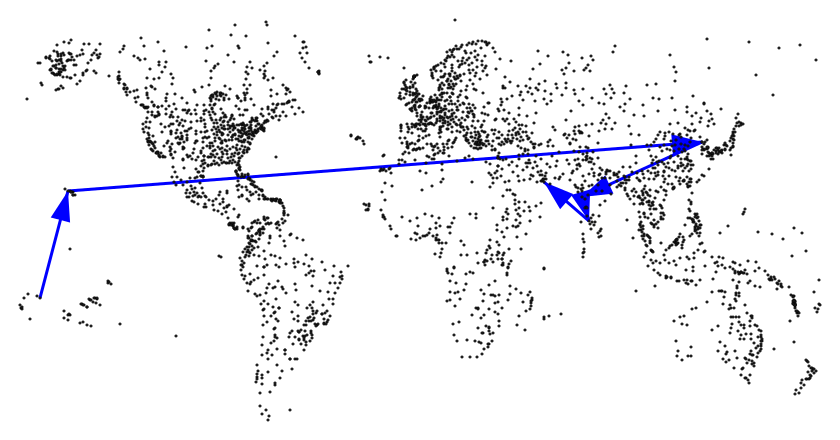

In [ ]:
SVG(image)

## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [ ]:
adjacency = openflights.adjacency>0

In [ ]:
distances = get_distances(adjacency, cdg)

In [ ]:
distant_airport = airports[np.argmax(distances)]
distant_airport

'Peawanuck Airport'

In [ ]:
for k in range(4):
  print(np.sum(distances <= k))

1
234
1917
2815


In [ ]:
adjacency = wikivitals.adjacency>0

In [ ]:
distances = get_distances(adjacency, cdg)

In [ ]:
for k in range(4):
  print(np.sum(distances <= k))

1
24
867
7977


## To do

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Write a function giving the corresponding path (longest shortest path).
* Give a path of **length 12** in Openflights (with the airport names) and display it.
* Give a path of **length 6** in WikiVitals (with the names of the articles).

In [ ]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph (longest shortest path).
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter. 
    '''    
    n = adjacency.shape[0]
    # start from random nodes
    nodes = np.random.choice(n, size=n_samples)
    distances = distance(adjacency.T, sources=nodes)
    distances[distances == np.inf] = -1
    # get the corresponding furthest nodes
    nodes_far = distances.argmax(axis=1)    
    distances = distance(adjacency, sources=nodes_far)
    distances[distances == np.inf] = -1
    # take the longest shortest path from these nodes 
    diameter = distances.max()
    return int(diameter)

In [ ]:
adjacency = openflights.adjacency>0

In [ ]:
estimate_diameter(adjacency)

12

In [ ]:
diameter(adjacency, 1000)

12

In [ ]:
def estimate_diameter_path(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Return a path of length equal to the (estimated) diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    path:
        List of nodes. 
    '''    
    # to be modified
    n = adjacency.shape[0]
    # start from random nodes
    nodes = np.random.choice(n, size=n_samples)
    distances = distance(adjacency.T, sources=nodes)
    distances[distances == np.inf] = -1
    # get the corresponding furthest nodes
    nodes_far = distances.argmax(axis=1)    
    distances = distance(adjacency, sources=nodes_far)
    distances[distances == np.inf] = -1
    # take the longest shortest path from these nodes 
    ind = np.where(distances == distances.max())

    source = ind[0][0]
    dest = ind[1][0]
    path = shortest_path(adjacency, source, dest)
    return path

In [ ]:
path = estimate_diameter_path(adjacency, 1000)

In [ ]:
print(path)

[0, 4, 1040, 293, 8, 1958, 2230, 2228, 9]


## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.
* Which fraction of actors have a Bacon number of 3 at most?

In [ ]:
biadjacency = cinema.biadjacency

In [ ]:
adjacency = bipartite2undirected(biadjacency)
adjacency

<133026x133026 sparse matrix of type '<class 'numpy.bool_'>'
	with 608012 stored elements in Compressed Sparse Row format>

In [ ]:
n_row, n_col = biadjacency.shape
n_row

88440

In [ ]:
cinema.names_row

array(['$1,000 a Touchdown', '$9.99', '$', ...,
       'Šta se zgodi kad se ljubav rodi', 'Želary', '’O Re'], dtype='<U95')

In [ ]:
names = cinema.names_col
names

array(['Joe E. Brown', 'Eric Blore', 'Susan Hayward', ...,
       'Olivier Saladin', 'Reona Hirota', 'Leyla Sayar'], dtype='<U95')

In [ ]:
{i:name for i,name in enumerate(names) if 'Bacon' in name}

{2994: 'Frank Bacon',
 3465: 'Kevin Bacon',
 4052: 'Lloyd Bacon',
 10011: 'Irving Bacon',
 18496: 'Max Bacon',
 39070: 'David Bacon'}

In [ ]:
bacon = n_row + 3465
bacon

91905

In [ ]:
n = adjacency.shape[0]
n

133026

In [ ]:
n_row + n_col

133026

In [ ]:
distances = get_distances(adjacency, bacon)
bacon_numbers = distances[n_row:] // 2

(array([1.0000e+00, 2.1900e+02, 0.0000e+00, 6.6930e+03, 1.8781e+04,
        0.0000e+00, 1.4084e+04, 3.9950e+03, 0.0000e+00, 6.3200e+02,
        1.2700e+02, 0.0000e+00, 2.9000e+01, 9.0000e+00, 0.0000e+00,
        3.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00, 3.0000e+00]),
 array([ 0.  ,  0.65,  1.3 ,  1.95,  2.6 ,  3.25,  3.9 ,  4.55,  5.2 ,
         5.85,  6.5 ,  7.15,  7.8 ,  8.45,  9.1 ,  9.75, 10.4 , 11.05,
        11.7 , 12.35, 13.  ]),
 <a list of 20 Patch objects>)

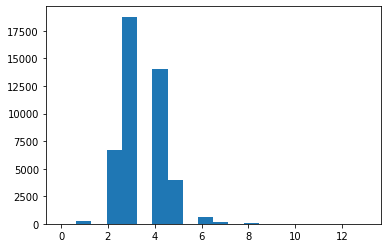

In [ ]:
plt.hist(bacon_numbers, bins = 20)

In [ ]:
{i:name for i,name in enumerate(names) if 'Monica Bellucci' in name}

{2644: 'Monica Bellucci'}

In [ ]:
distances[n_row+2644] // 2

2.0

## 3. Clustering coefficient

The computation of the clustering coefficient of a graph is time-consuming.
You will now learn to **estimate** it.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Check your code on the triange, then on the karate club graph using ``Triangles``.
* Estimate the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph) and compare with that of equivalent Erdos-Rényi graphs (same number of nodes, same average degree).

**Hint:** A triangle is... a cycle of length 3

In [ ]:
def get_clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 100) -> float:
    '''Get the clustering coefficient of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph (binary).
    
    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''
    clustering_coef = 0
    # sample nodes
    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)
    # compute the clustering coefficient for these samples
    # to be modified
    algo = Triangles()
    algo.fit(adjacency[nodes][nodes])
    clustering_coef = algo.clustering_coef_
    return clustering_coef

In [ ]:
triangle = cyclic_graph(3)

In [ ]:
triangle.todense()

matrix([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])

In [ ]:
algo = Triangles()

In [ ]:
algo.fit(triangle)

Triangles(parallelize=False)

In [ ]:
algo.n_triangles_

1

In [ ]:
algo.clustering_coef_

1.0

In [ ]:
adjacency = karate_club()

In [ ]:
image = svg_graph(adjacency)

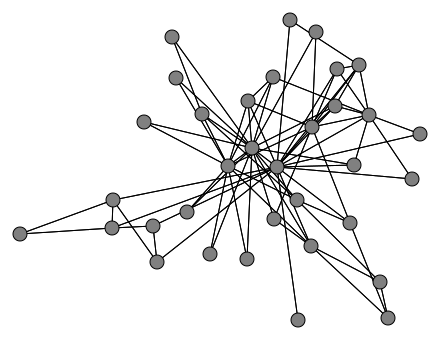

In [ ]:
SVG(image)

In [ ]:
algo.fit(adjacency)

Triangles(parallelize=False)

In [ ]:
algo.clustering_coef_

0.2556818181818182

In [ ]:
algo.n_triangles_

45

In [ ]:
get_clustering_coefficient(triangle)

1.0

In [ ]:
get_clustering_coefficient(adjacency)

0.2556818181818182